In [1]:
import SCOTCH
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import pooch
import matplotlib.pyplot as plt

### Loading single cell data 

SCOTCH allows loading through three interfaces, plain text files, anndata objects, or pytorch pt. files. For this example we will work with the exampledata scat is used for the scverse and scanpy tutorials. The data that are using is the 2021 NeurIPS benchmarking dataset. The samples used in this data were measured with the 10X multiome gene expression and chromatin accessibility kit. We will focus on the filtered expression matrices. That data contains ~16,000 from two different donors and span 36,601 genes. 

For this tutorial we utilize the beginning of the guide for scanpy which downloads the data into a standard adata object (adata). 

In [2]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [3]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())

/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


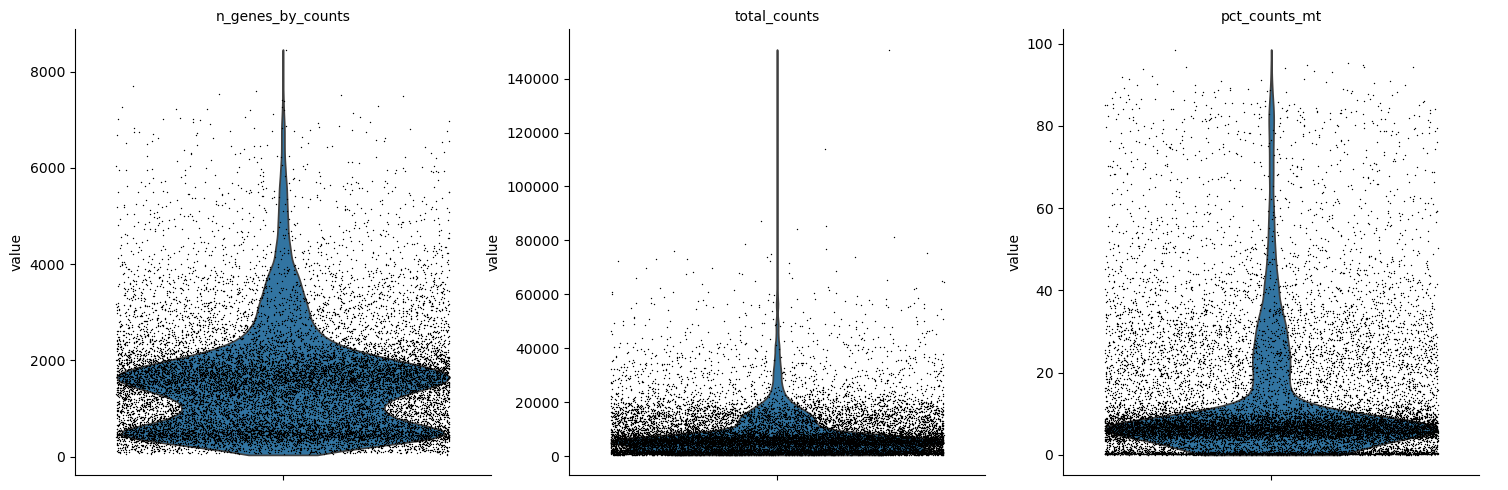

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

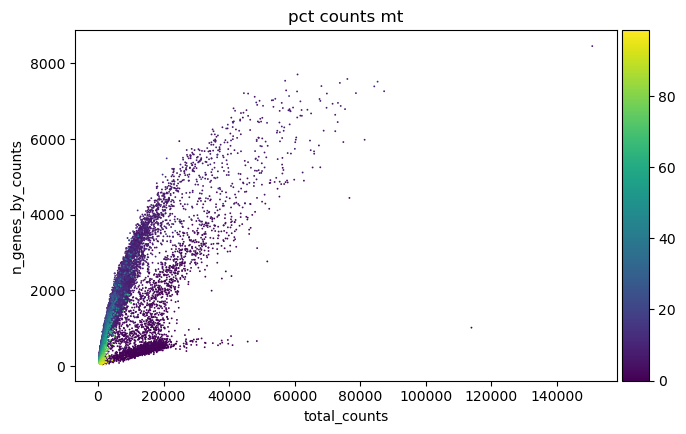

In [5]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [6]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
#sc.pp.scrublet(adata, batch_key="sample")

In [7]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
adata_high_var = adata[:, adata.var["highly_variable"]]

### Initializing a SCOTCH object

Now we can initialize SCOTCH. SCOTCH is a matrix tri factorization approach that estimates the data as multiplication of three matrices. 

$X \approx U S V^{T}$ where $U$ is a near orthogonal matrix which is used to cluster the cell space, $V$ is a near orthogonal matrix which is used to cluster the gene space, and $S$ is relationship matrix which relates gene and cell clusters. 

To start SCOTCH we need to initialize a SCOTCH object, and specify the number of cluster we want to use for the cell space (k1), and the number of cluster for the gene space (k2). We can also specify regularization parameters such as $\lambda_u$ or $\lambda_v$ which can be tuned to improve the orthogonality of the cell and gene clusters respectively. 


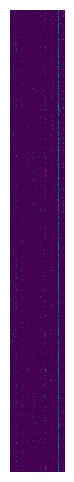

In [9]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
X_dense = adata_high_var.X.toarray() if hasattr(adata_high_var.X, 'toarray') else adata_high_var.X
ax.imshow(X_dense, interpolation="nearest", cmap='viridis')
ax.set_axis_off()

In [10]:
scotch = SCOTCH.SCOTCH(k1=3, k2=5, max_l_u=0.15, max_l_v=0.15, term_tol=1e-5, var_lambda=False, device="cpu",
                       init_style="random", verbose=True)
scotch.add_data_from_adata(adata_high_var)
scotch.send_to_gpu()


In [11]:
scotch.fit()

Initializing NMTF factors
Beginning NMTF
Iter: 1	Iter Time: 2.411	Total Time: 2.411	Objective: 2.610e+06	Relative Delta Objective: 3.740e-01	Reconstruction Error: 2.610e+06
Iter: 2	Iter Time: 1.345	Total Time: 3.756	Objective: 2.363e+06	Relative Delta Objective: 9.445e-02	Reconstruction Error: 2.363e+06
Iter: 3	Iter Time: 1.327	Total Time: 5.083	Objective: 2.352e+06	Relative Delta Objective: 4.557e-03	Reconstruction Error: 2.352e+06
Iter: 4	Iter Time: 1.365	Total Time: 6.448	Objective: 2.345e+06	Relative Delta Objective: 3.124e-03	Reconstruction Error: 2.345e+06
Iter: 5	Iter Time: 1.322	Total Time: 7.770	Objective: 2.311e+06	Relative Delta Objective: 1.433e-02	Reconstruction Error: 2.311e+06
Iter: 6	Iter Time: 1.329	Total Time: 9.099	Objective: 2.179e+06	Relative Delta Objective: 5.743e-02	Reconstruction Error: 2.179e+06
Iter: 7	Iter Time: 1.326	Total Time: 10.425	Objective: 1.993e+06	Relative Delta Objective: 8.508e-02	Reconstruction Error: 1.993e+06
Iter: 8	Iter Time: 1.321	Total Tim

In [12]:
scotch.send_to_cpu()
scotch.assign_cluster()
adata_high_var = scotch.add_scotch_embeddings_to_adata(adata_high_var, "lU_lV_0.1")

/Users/shalberg/Desktop/SCOTCH/SCOTCH.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[prefix + 'cell_clusters'] = pd.Categorical(self.U_assign.detach().numpy())


In [13]:
adata_high_var

AnnData object with n_obs × n_vars = 17041 × 2000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'lU_lV_0.1_cell_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'lU_lV_0.1_gene_clusters'
    uns: 'log1p', 'hvg', 'lU_lV_0.1_S_matrix', 'lU_lV_0.1_reconstruction_error', 'lU_lV_0.1_error'
    obsm: 'lU_lV_0.1_cell_embedding', 'lU_lV_0.1_P_embedding'
    varm: 'lU_lV_0.1_gene_

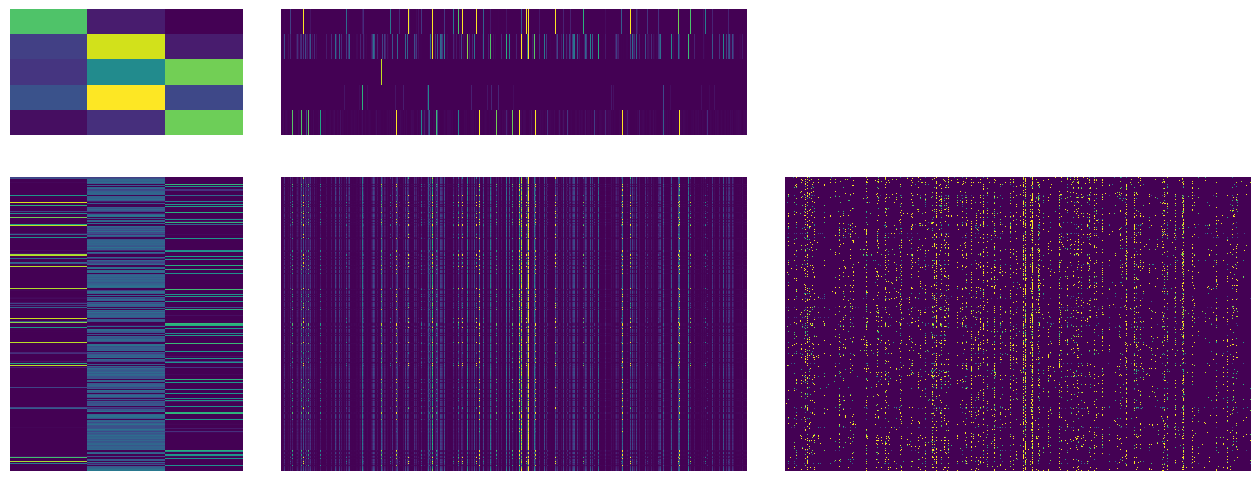

In [14]:
scotch.visualize_factors(max_u=1, max_v=0.1, max_x=0.1)

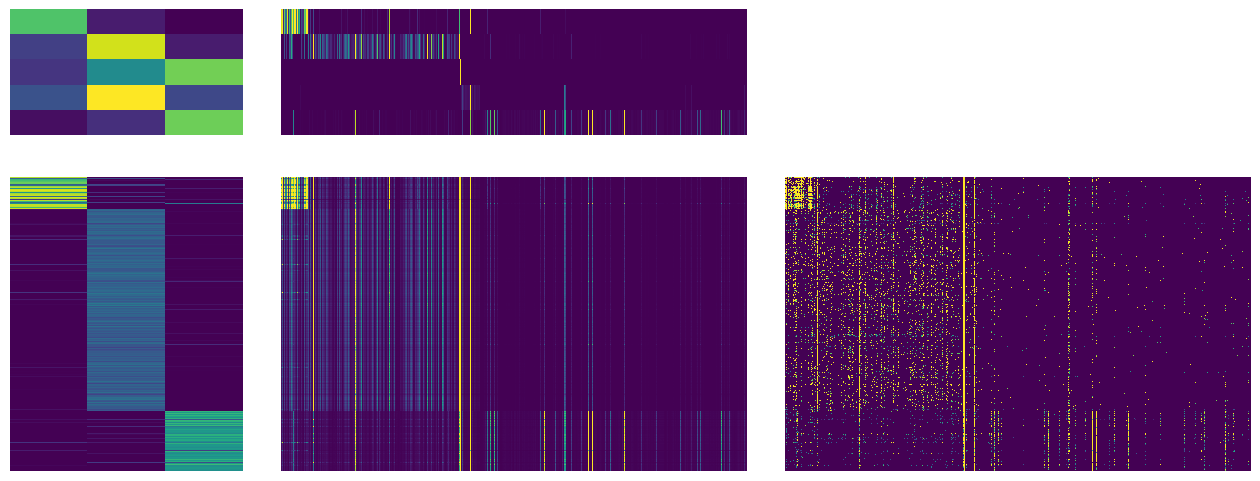

In [15]:
scotch.visualize_factors_sorted(max_v=0.1, max_x=0.1)

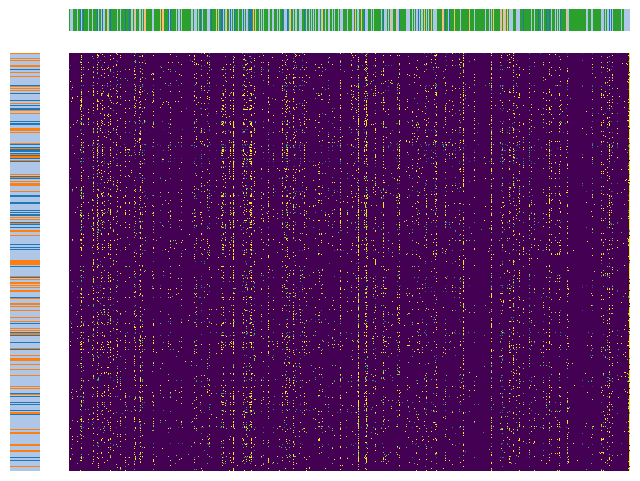

In [16]:
scotch.visualize_clusters(max_x=0.1)

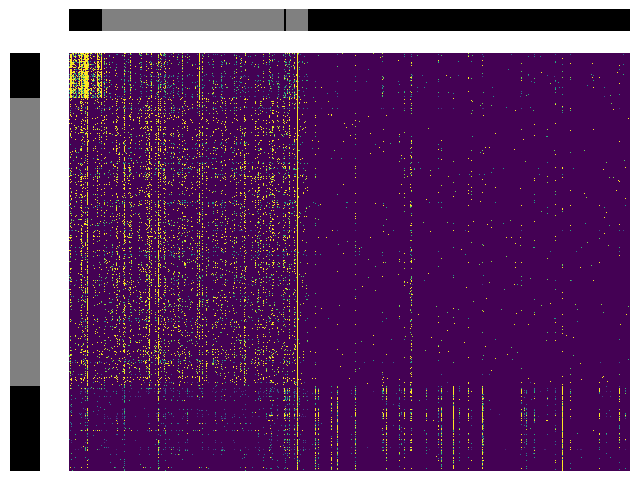

In [17]:
scotch.visualize_clusters_sorted(max_x=0.1)

In [18]:
sc.pp.pca(adata_high_var)
sc.pp.neighbors(adata_high_var, use_rep= "X_pca", metric = "cosine")
sc.tl.umap(adata_high_var)

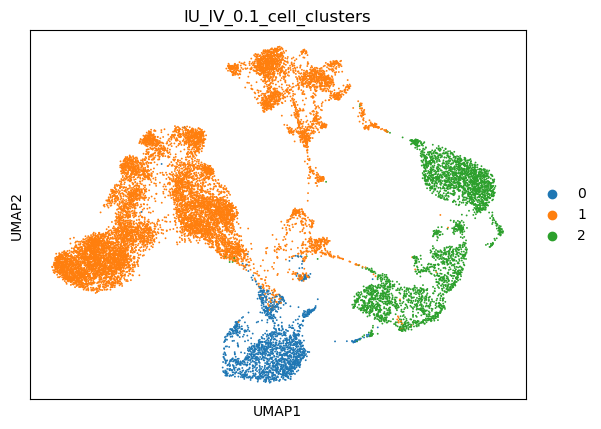

In [19]:
sc.pl.umap(adata_high_var, color = "lU_lV_0.1_cell_clusters")

In [20]:
#sc.pp.neighbors(adata_high_var, use_rep= "lU_lV_0.1_cell_embedding", metric = "cosine")
#sc.tl.umap(adata_high_var)
#sc.pl.umap(adata_high_var, color = "lU_lV_0.1_cell_clusters")

In [21]:
#sc.pp.neighbors(adata_high_var, use_rep= "lU_lV_0.1_P_embedding", metric = "cosine")
#sc.tl.umap(adata_high_var)
#sc.pl.umap(adata_high_var, color = "lU_lV_0.1_cell_clusters")

In [22]:
top_k = 5
top_genes = scotch.make_top_regulators_list(adata_high_var, prefix='lU_lV_0.1', top_k=top_k)

Gene Cluster 0: Index(['S100A9', 'S100A8', 'LYZ', 'CTSS', 'FCN1'], dtype='object')
Gene Cluster 1: Index(['MT-ND2', 'MT-ND5', 'JUN', 'IGKC', 'CD74'], dtype='object')
Gene Cluster 2: Index(['HBB', 'HBA2', 'TFRC', 'SMC4', 'HECTD4'], dtype='object')
Gene Cluster 3: Index(['MALAT1', 'MTRNR2L12', 'FTH1', 'FTL', 'GOLGA4'], dtype='object')
Gene Cluster 4: Index(['HBA1', 'HBD', 'AHSP', 'HBM', 'SLC25A37'], dtype='object')


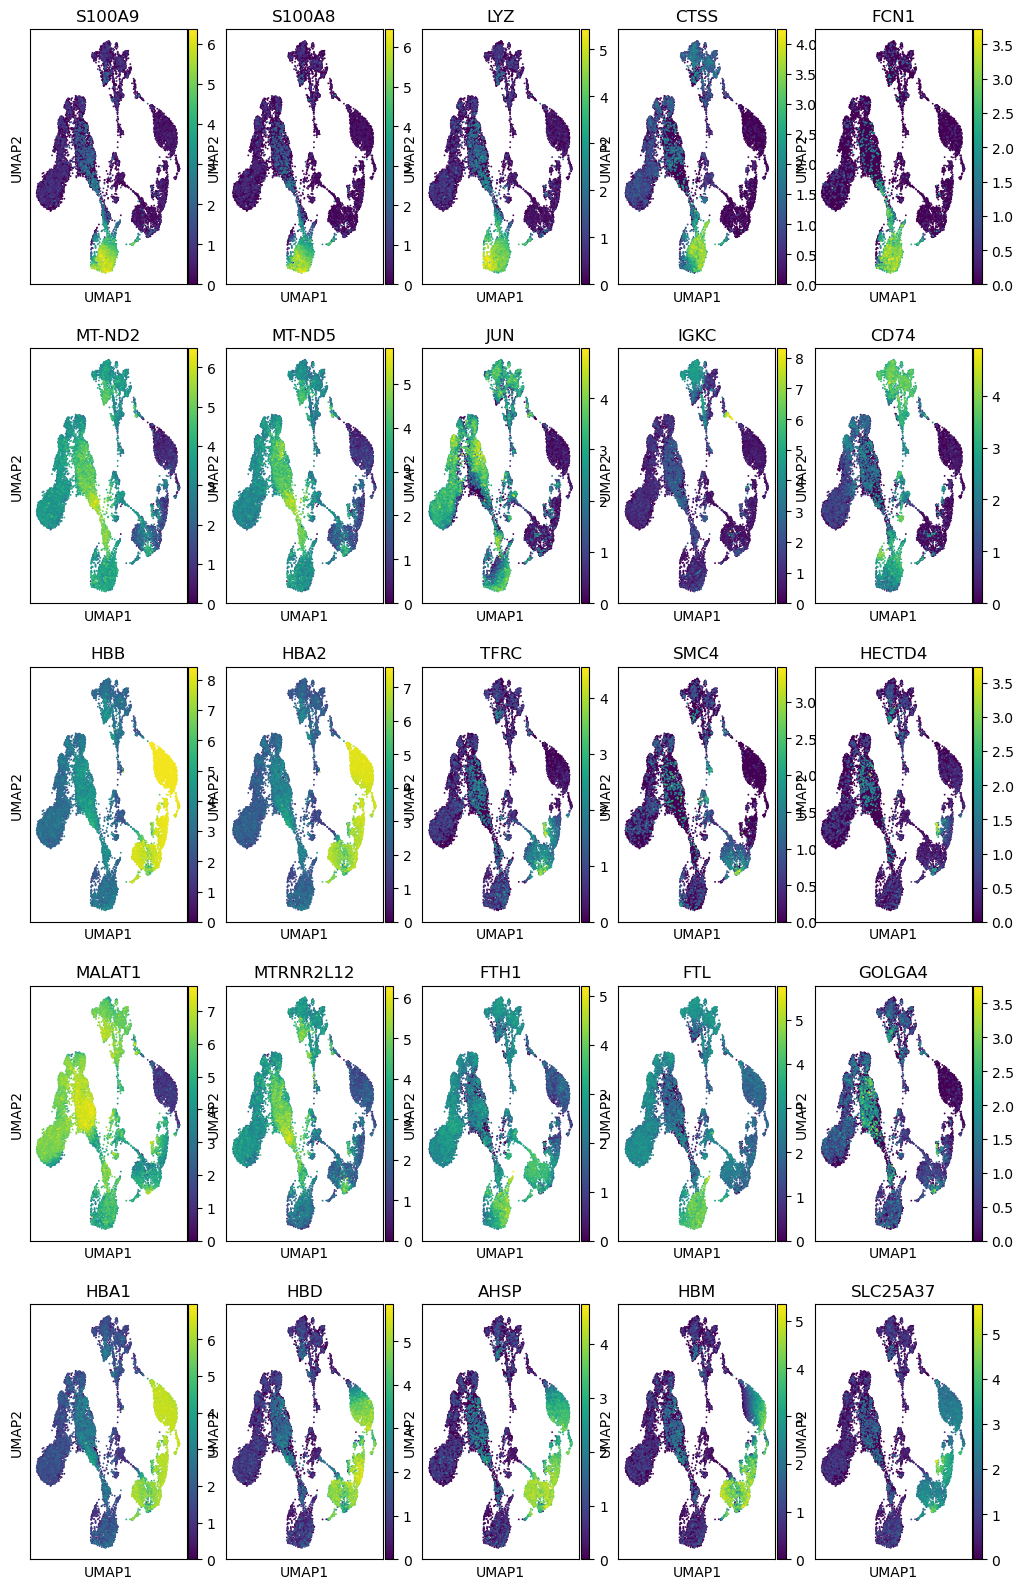

In [23]:
fig = sc.pl.umap(adata_high_var,
                 color=[gene for top_gene in top_genes for gene in top_gene[1]],
                 ncols=top_k,
                 return_fig=True
                 )
fig.set_size_inches(12, 18)

In [24]:
adata_high_var

AnnData object with n_obs × n_vars = 17041 × 2000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'lU_lV_0.1_cell_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'lU_lV_0.1_gene_clusters'
    uns: 'log1p', 'hvg', 'lU_lV_0.1_S_matrix', 'lU_lV_0.1_reconstruction_error', 'lU_lV_0.1_error', 'pca', 'neighbors', 'umap', 'lU_lV_0.1_cell_clusters_colors'
    obsm: 'lU_lV_0.1_cell_

Gene Cluster 0: Index(['S100A9', 'S100A8', 'LYZ', 'CTSS', 'FCN1'], dtype='object')
Gene Cluster 1: Index(['MT-ND2', 'MT-ND5', 'JUN', 'IGKC', 'CD74'], dtype='object')
Gene Cluster 2: Index(['HBB', 'HBA2', 'TFRC', 'SMC4', 'HECTD4'], dtype='object')
Gene Cluster 3: Index(['MALAT1', 'MTRNR2L12', 'FTH1', 'FTL', 'GOLGA4'], dtype='object')
Gene Cluster 4: Index(['HBA1', 'HBD', 'AHSP', 'HBM', 'SLC25A37'], dtype='object')


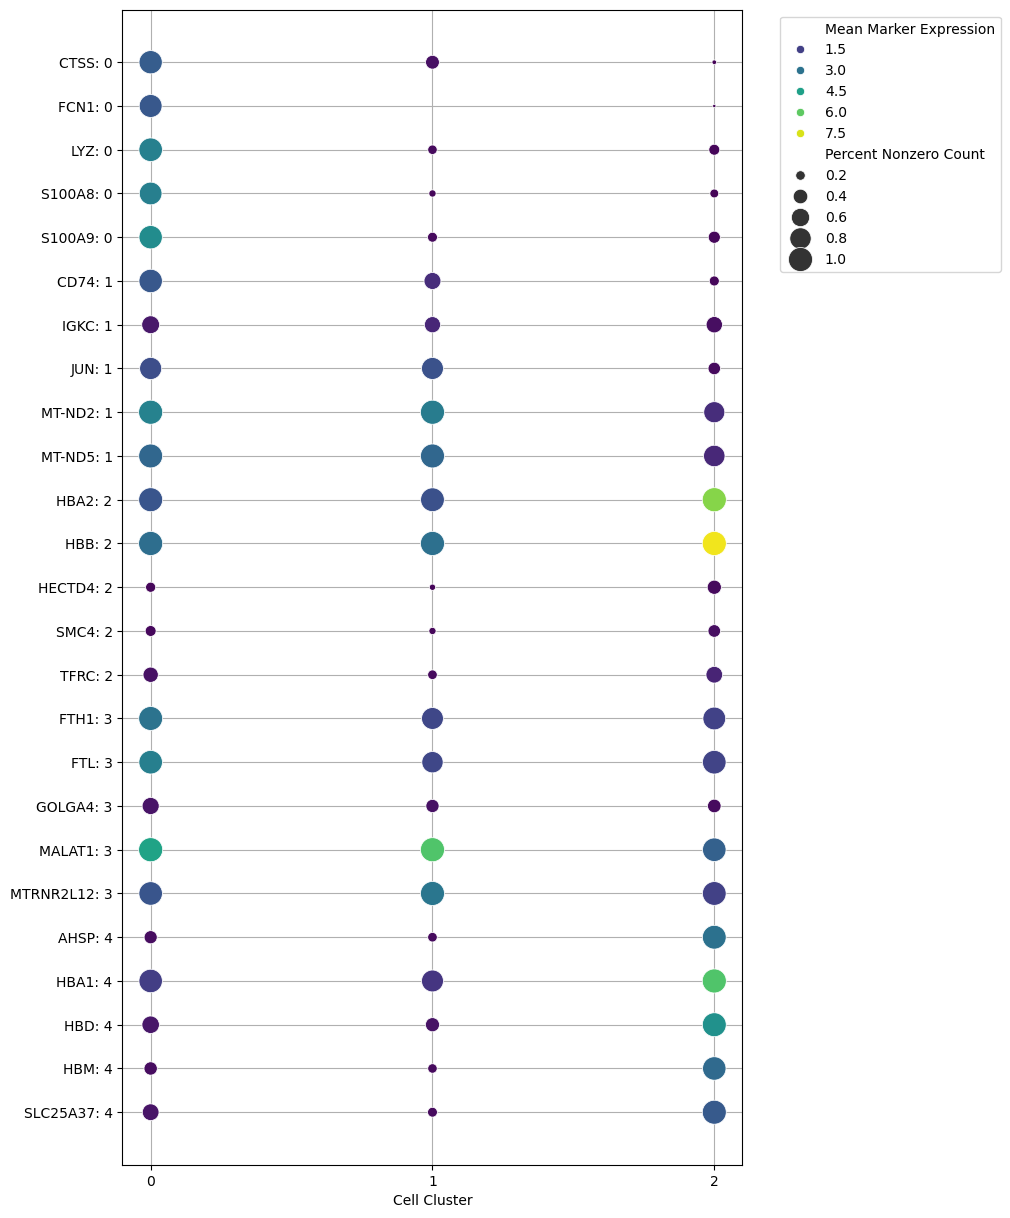

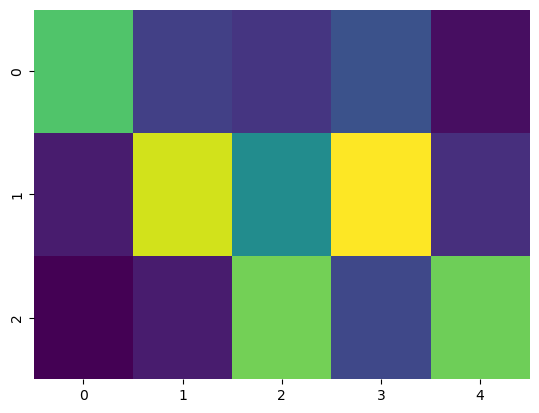

In [25]:
fig = scotch.visualize_marker_gene_bubbleplot_per_cell_cluster(adata_high_var,
                                                               cell_cluster_id="lU_lV_0.1_cell_clusters",
                                                               gene_cluster_id="lU_lV_0.1_gene_clusters",
                                                               gene_embedding_id='lU_lV_0.1_gene_embedding',
                                                               palette='viridis')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

scotch.plot_S_matrix(adata = adata_high_var, S_matrix_id="lU_lV_0.1_S_matrix")



In [26]:
scotch.run_enrich_analyzer(adata_high_var, 'lU_lV_0.1_gene_clusters',
                           go_regnet_file='test/geneontology_cnames_lev_3_4_regnet.txt')

Read in 3080 terms for  14451 genes
Pval 6.37705e-05 Corr 0.0339897
Pval 0.000149028 Corr 0.0397159
Pval 0.000160005 Corr 0.0284276
Pval 0.000304302 Corr 0.0405482
Pval 0.000650843 Corr 0.0693799
Pval 0.00184102 Corr 0.163544
Pval 0.0021993 Corr 0.167461
Pval 0.00321803 Corr 0.214401
Pval 0.00330832 Corr 0.195926
Pval 0.00351102 Corr 0.187137
Pval 0.00355305 Corr 0.172162
Pval 0.00440806 Corr 0.195791
Pval 0.0044536 Corr 0.182598
Pval 0.0044779 Corr 0.17048
Pval 0.00475897 Corr 0.169102
Pval 0.00484123 Corr 0.161273
Pval 0.00493351 Corr 0.15468
Pval 0.00493351 Corr 0.146087
Pval 0.00528064 Corr 0.148136
Pval 0.00546504 Corr 0.145643
Pval 0.00627226 Corr 0.159196
Pval 0.0070096 Corr 0.169823
Pval 0.00738428 Corr 0.171123
Pval 0.00924522 Corr 0.205321
Pval 0.00924522 Corr 0.197108
Pval 0.0118192 Corr 0.242294
Pval 0.0140812 Corr 0.277974
Pval 0.0206564 Corr 0.393209
Pval 0.0268825 Corr 0.494082
Pval 0.0275887 Corr 0.490159
Pval 0.0307559 Corr 0.528803
Pval 0.0318137 Corr 0.529896
Pval 0.

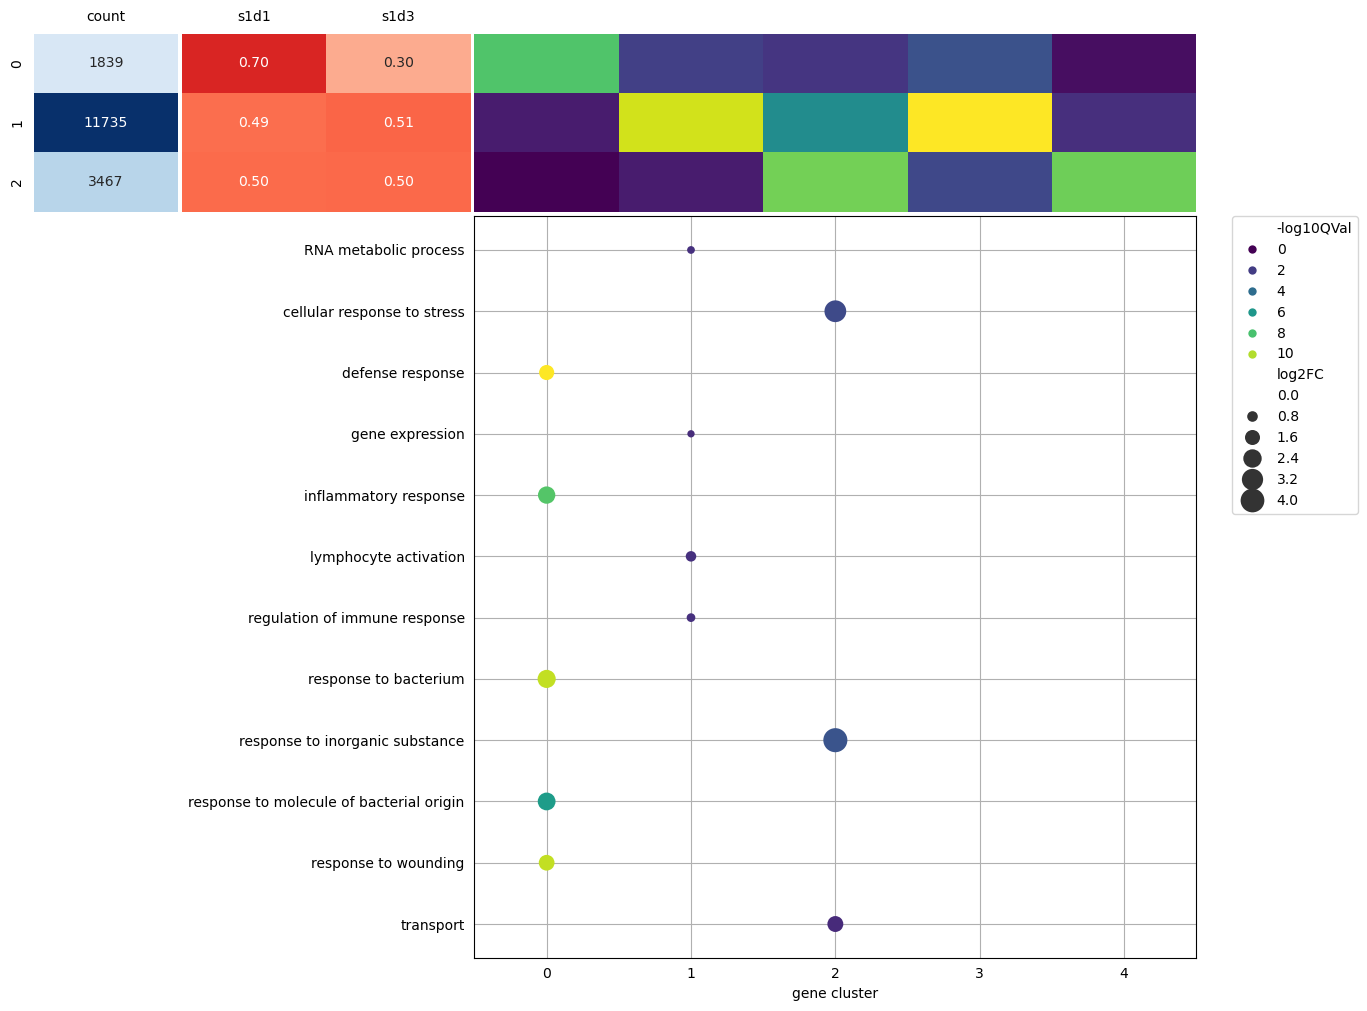

In [27]:
fig = scotch.combined_enrichment_visualization(adata_high_var, enrich_object_id='GO_enrichment',
                                               var1='lU_lV_0.1_cell_clusters', var2='sample',
                                               S_matrix_id='lU_lV_0.1_S_matrix')
fig.subplots_adjust(hspace=0.01, wspace=0.01)


Gene Cluster 0: Index(['S100A9', 'S100A8', 'LYZ', 'CTSS', 'FCN1'], dtype='object')
Gene Cluster 1: Index(['MT-ND2', 'MT-ND5', 'JUN', 'IGKC', 'CD74'], dtype='object')
Gene Cluster 2: Index(['HBB', 'HBA2', 'TFRC', 'SMC4', 'HECTD4'], dtype='object')
Gene Cluster 3: Index(['MALAT1', 'MTRNR2L12', 'FTH1', 'FTL', 'GOLGA4'], dtype='object')
Gene Cluster 4: Index(['HBA1', 'HBD', 'AHSP', 'HBM', 'SLC25A37'], dtype='object')


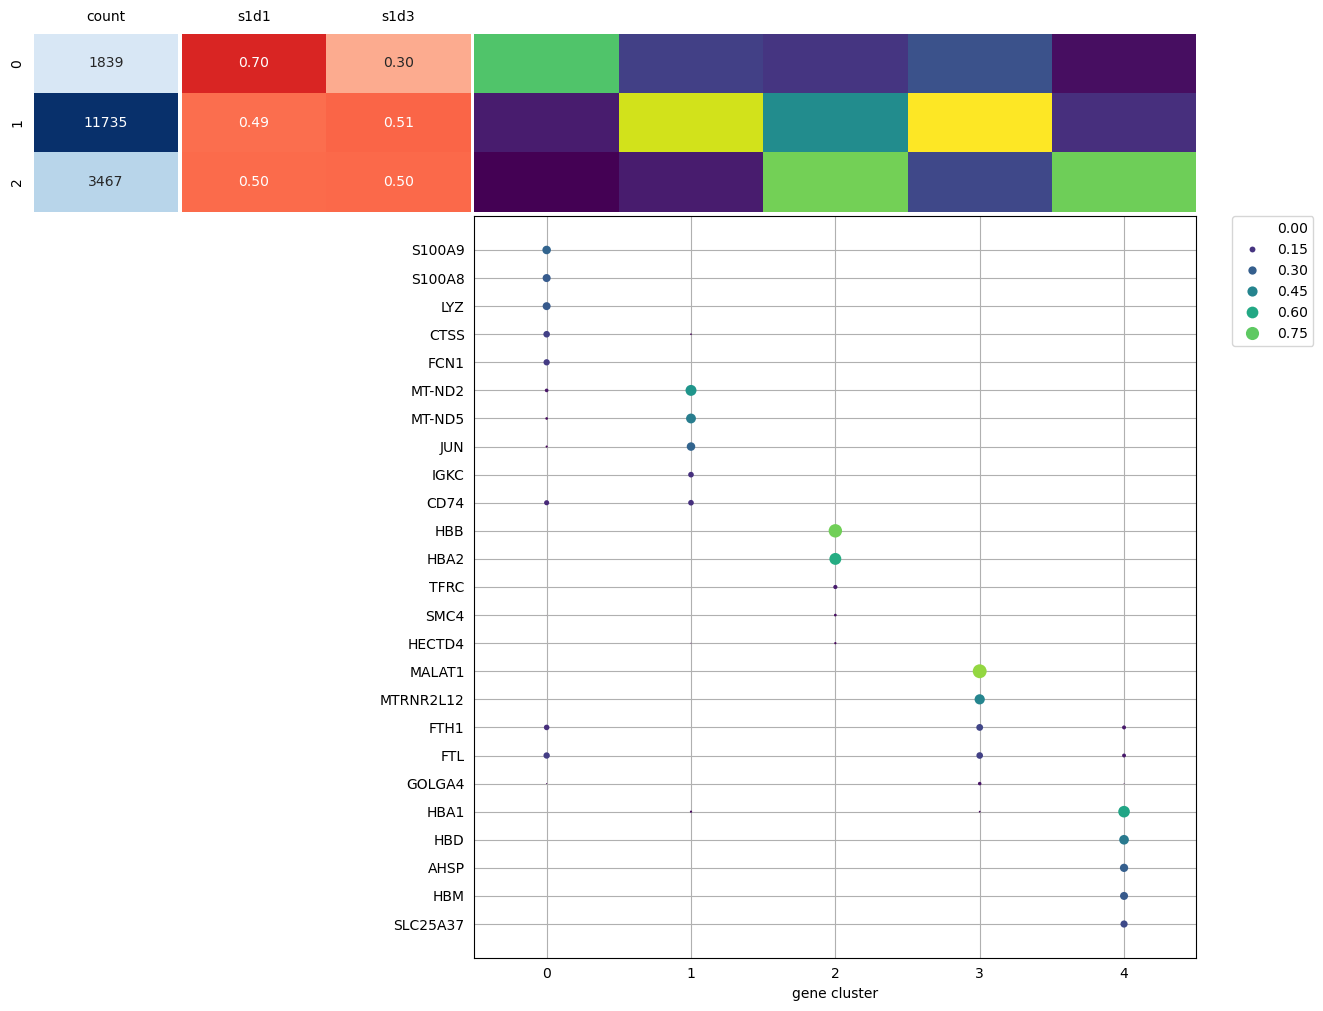

In [28]:
fig = scotch.combined_embedding_visualization(adata_high_var,
                                              gene_cluster_id ='lU_lV_0.1_gene_clusters',
                                              gene_embedding_id='lU_lV_0.1_gene_embedding',
                                              var1='lU_lV_0.1_cell_clusters', var2='sample',
                                              S_matrix_id='lU_lV_0.1_S_matrix')
fig.subplots_adjust(hspace=0.01, wspace=0.01)

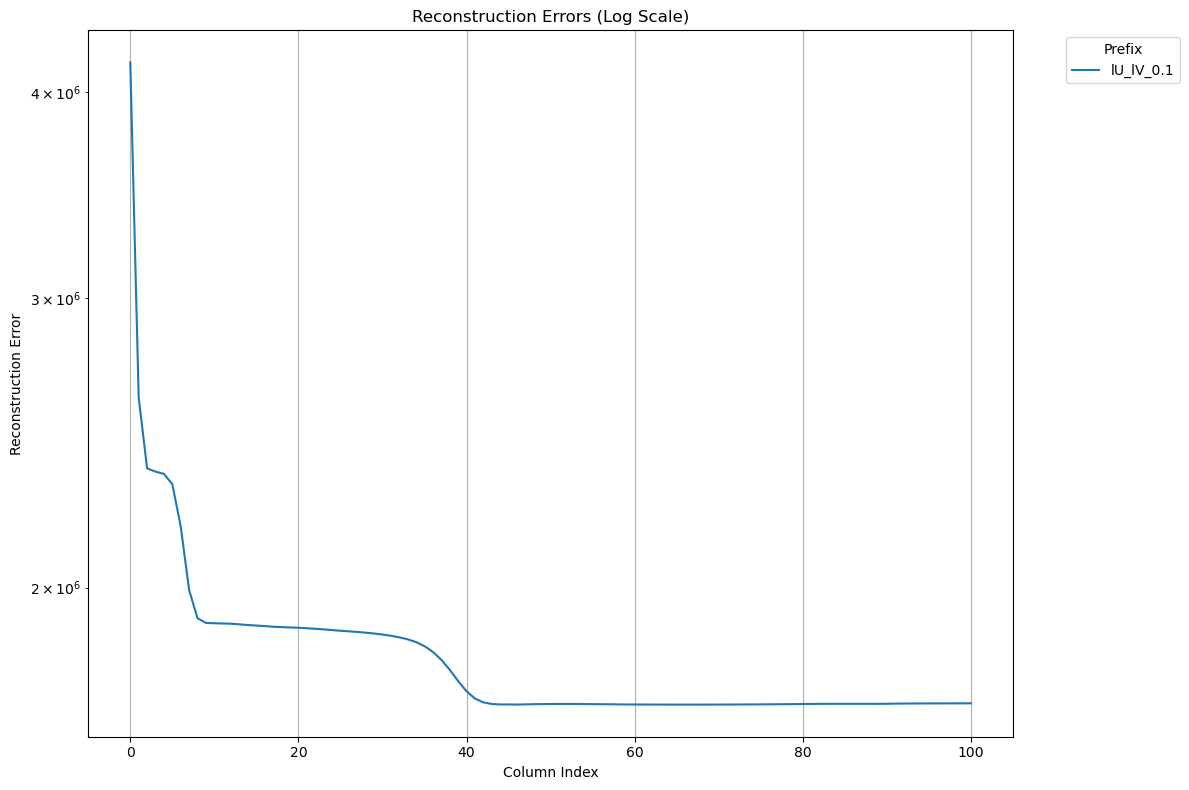

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract keys matching the pattern '*_reconstruction_error'
reconstruction_error_keys = [key for key in adata_high_var.uns if key.endswith('_reconstruction_error')]

# Create line plot for each key
plt.figure(figsize=(12, 8))
for key in reconstruction_error_keys:
    prefix = key.split('_reconstruction_error')[0]
    reconstruction_error = adata_high_var.uns[key].flatten()
    sns.lineplot(x=range(len(reconstruction_error)), y=reconstruction_error, label=prefix)

plt.yscale('log')
plt.title('Reconstruction Errors (Log Scale)')
plt.xlabel('Column Index')
plt.ylabel('Reconstruction Error')
plt.legend(title='Prefix', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()